# iris tomography codes and other stuff

In [1]:
import sqlite3 as sql
import sys
sys.path.append('..')
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interp1d
from netCDF4 import num2date
units = 'days since 1858-11-17 00:00:00.000'

## import data from database

In [2]:
orbit = 20900
num_of_orbits = 1
ch = 3

db = sql.connect('../OSIRIS_three_orbits_test.db')
cur = db.cursor()

return_column = ('data, mjd, look_ecef, sc_position_ecef, latitude, longitude, altitude')              
select_str = 'SELECT {} FROM IRI JOIN channel{} ON IRI.stw = channel{}.stw WHERE orbit>={} AND orbit<={}'
result = cur.execute(select_str.format(return_column, ch, ch, orbit, orbit+num_of_orbits))
all_image = result.fetchall()
db.close()

if len(all_image) == 0:
    print('No data for this orbit(s)')
    

print('num of images: {}'.format(len(all_image)))

l1_blob = np.array(all_image)[:,0]
mjd = np.array(all_image)[:,1].astype(float)
date = num2date(mjd, units)
sc_look_blob = np.array(all_image)[:,2]
sc_pos_blob = np.array(all_image)[:,3]
tan_lat_blob = np.array(all_image)[:,4]
tan_lon_blob = np.array(all_image)[:,5]
tan_alt_blob = np.array(all_image)[:,6]

#====unfolding blobs
l1 = np.empty((len(all_image),128))
sc_look = np.empty((len(all_image), 128, 3))
sc_pos = np.empty((len(all_image), 3))
tan_lat = np.empty((len(all_image),128))
tan_lon = np.empty((len(all_image),128))
tan_alt = np.empty((len(all_image),128))
for i in range(len(all_image)):
    l1[i,:] = np.frombuffer(l1_blob[i])
    sc_look[i,:,:] = np.frombuffer(sc_look_blob[i]).reshape(128,3)
    sc_pos[i,:] = np.frombuffer(sc_pos_blob[i])
    tan_lat[i,:] = np.frombuffer(tan_lat_blob[i])
    tan_lon[i,:] = np.frombuffer(tan_lon_blob[i])
    tan_alt[i,:] = np.frombuffer(tan_alt_blob[i])
#====construct xarray data array
pixel = np.arange(128)
l1 = xr.DataArray(l1, coords=(date, pixel), 
                  dims=('date', 'pixel'), 
                  attrs={'units':'Rayleigh??'})
sc_look = xr.DataArray(sc_look, coords=(date, pixel, ['x', 'y', 'z']), 
                       dims=('date', 'pixel', 'xyz'))
sc_pos = xr.DataArray(sc_pos, coords=(date, ['x', 'y', 'z']), dims=('date', 'xyz'))
tan_lat = xr.DataArray(tan_lat, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_lon = xr.DataArray(tan_lon, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'degree'})
tan_alt = xr.DataArray(tan_alt, coords=(date, pixel),
                       dims=('date', 'pixel'), attrs={'units':'meter'})
import pandas as pd
from geometry_functions import lla2ecef
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), pd.Index(['x','y','z'], name='xyz'))


num of images: 5792


# coordinate transformation (functions)

In [3]:
def change_of_basis(e1, e2, e3, v):
    #e1, e2, e3 are the new base vectors 
    #v is the coordinate with respect to the original base vectors
    #v_new is the coordinate with respect to the new base vectors
    #normalize all base vectors to unit length 1
    e1 = e1/np.linalg.norm(e1)
    e2 = e2/np.linalg.norm(e2)
    e3 = e3/np.linalg.norm(e3)
    
    Q = np.array([e1, e2, e3]).T
    #print('Transformed to original system with \n Q={}'.format(Q))
    
    v_new = np.linalg.solve(Q,v)
    #print('The vector in the new coordinates \n v_new={}'.format(v_new))

    if type(v) is xr.core.dataarray.DataArray:
        v_new = xr.DataArray(v_new, coords=v.coords, dims=v.dims)
    return v_new

def cart2sphe(e1, e2, e3):
    #from cartesian system to geocentric spherical corrdinate system
    #(ex. 
    #alpha: across-track angle, 
    #beta: along-track angle, 
    #rho: distance from origin)
    alpha = np.arctan(e1/e3)
    beta = np.arctan(e2/e3)
    rho = np.sqrt(e1**2 + e2**2 + e3**2) - 6371e3
    return alpha, beta, rho


[8. 7. 9.]


# build jacobian for the chosen images and pixels

In [73]:
#====choose mesurements
im_lst = np.arange(500,700, 1)
pix_lst = np.arange(22,128)
#num of rows of jacobian
row_len = len(im_lst) * len(pix_lst)

#====define the new base vectors
n_crosstrack = np.cross(sc_look.isel(date=im_lst[0], pixel=60),
                        sc_pos.isel(date=im_lst[0]))
n_vel = np.cross(sc_pos.isel(date=im_lst[0]), n_crosstrack)
n_zenith = sc_pos.isel(date=im_lst[0])

#====tangent points in alpha, beta, rho coordinate
import pandas as pd
from geometry_functions import lla2ecef
tan_ecef = xr.concat(lla2ecef(tan_lat,tan_lon,tan_alt), 
                     pd.Index(['x','y','z'], name='xyz'))

tan_alpha = []
tan_beta = []
tan_rho = []
for i in im_lst:
    p_old = tan_ecef.isel(date=i, pixel=pix_lst)
    p_new = change_of_basis(n_crosstrack, n_vel, n_zenith, p_old)
    alpha, beta, rho = cart2sphe(p_new.sel(xyz='x'),
                                 p_new.sel(xyz='y'),
                                 p_new.sel(xyz='z'))
    tan_alpha.append(alpha)
    tan_beta.append(beta)
    tan_rho.append(rho)
tan_alpha = xr.DataArray(tan_alpha, 
                         coords=[date[im_lst], pixel[pix_lst]],
                         dims=['date', 'pixel'])
tan_beta = xr.DataArray(tan_beta, 
                        coords=[date[im_lst], pixel[pix_lst]],
                        dims=['date', 'pixel'])
tan_rho = xr.DataArray(tan_rho, 
                       coords=[date[im_lst], pixel[pix_lst]],
                       dims=['date', 'pixel'])

#====define atmosphere grid (the bin edges)
edges_alpha = np.linspace(tan_alpha.min()-0.01,
                          tan_alpha.max()+0.01, 10) #radiance
edges_beta = np.linspace(tan_beta.min()-0.1,
                         tan_beta.max()+0.1, 15) #radiance
edges_rho = np.arange(25e3, 175e3, 2e3) # meter
edges = edges_alpha, edges_beta, edges_rho


#====num of columns of jacobian
col_len = (len(edges_alpha)+1)*(len(edges_beta)+1)*(len(edges_rho)+1) 

#====measure pathlength in each bin
from geometry_functions import los_points_fix_dl
from oem_functions import jacobian_row

dl = 3e3 #fixed distance between all points
nop = 500 # choose number of points along the line
K_row_idx = []
K_col_idx = []
K_value = []
dll = dl * np.ones(nop) #temp
all_los_alpha, all_los_beta, all_los_rho = [], [], []
measurement_id = 0
for image in im_lst:
    #====generate points of los for all pixels in each image
    #====all points in cartesian coordinate relative to the space craft
    sc_look_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                  sc_look[image].T)
    sc_pos_new = change_of_basis(n_crosstrack, n_vel, n_zenith, 
                                 sc_pos[image])
    lx, ly, lz = los_points_fix_dl(sc_look_new, sc_pos_new, dl=dl, nop=nop)    
    #====convert xyz to alpha, beta, rho for all points
    los_alpha, los_beta, los_rho = cart2sphe(lx, ly, lz)
    all_los_alpha.append(los_alpha)
    all_los_beta.append(los_beta)
    all_los_rho.append(los_rho)
    
    #====build K
    for pix in pix_lst:#range(pix_start, pix_end):   
        los = los_alpha.sel(pixel=pix), los_beta.sel(pixel=pix), los_rho.sel(pixel=pix)
        measurement_idx, grid_idx, pathlength = jacobian_row(dll, edges, los, measurement_id)
        K_row_idx.append(measurement_idx)
        K_col_idx.append(grid_idx)
        K_value.append(pathlength)
        measurement_id += 1
        
        
K_row_idx = np.concatenate(K_row_idx).astype('int')
K_col_idx = np.concatenate(K_col_idx).astype('int')
K_value = np.concatenate(K_value) # in meter

#==== create sparse matrix
from scipy.sparse import coo_matrix
K_coo = coo_matrix((K_value, (K_row_idx, K_col_idx)), shape = (row_len, col_len))
#print(K_coo)

# MAP inversion

In [74]:
from oem_functions import linear_oem_sp
import scipy.sparse as sp
y = l1.isel(date=im_lst, pixel=pix_lst).data.ravel()
y[y<0] = 0
xa = np.ones(col_len) # temp
Sa = sp.diags([1], shape=(col_len, col_len)) *1 #temp
Se = sp.diags([1], shape=(measurement_id, measurement_id)) * 1e10 #temporary
x_hat, G = linear_oem_sp(K_coo, Se, Sa, y, xa)

result = x_hat.reshape(len(edges_alpha)+1, len(edges_beta)+1, len(edges_rho)+1)
result = xr.DataArray(result[:-1,:-1,:-1], coords=(edges_alpha, edges_beta, edges_rho), 
                      dims=('alpha', 'beta', 'rho')) #temp

/home/anqil/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:295: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/anqil/anaconda3/lib/python3.6/site-packages/scipy/sparse/linalg/dsolve/linsolve.py:202: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  'is in the CSC matrix format', SparseEfficiencyWarning)


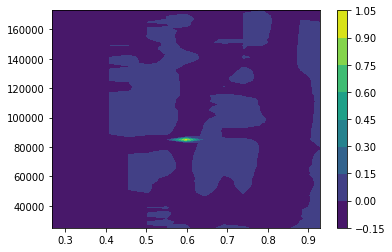

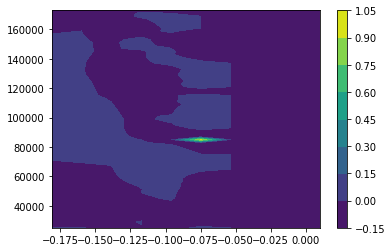

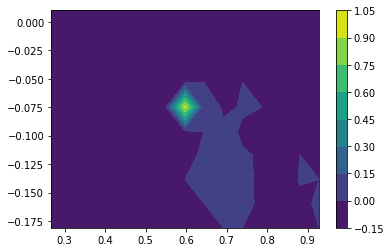

In [75]:
A = G.dot(K_coo)
A_row = A[6642,:]
AAA = A_row.toarray().squeeze().reshape(len(edges_alpha)+1, len(edges_beta)+1, len(edges_rho)+1)
plt.contourf(edges_beta, edges_rho, AAA[:-1, :-1, :-1].sum(axis=0).T)
plt.colorbar()

plt.figure()
plt.contourf(edges_alpha, edges_rho, AAA[:-1, :-1, :-1].sum(axis=1).T)
plt.colorbar()


plt.figure()
plt.contourf(edges_beta, edges_alpha, AAA[:-1, :-1, 30])
plt.colorbar()

In [61]:
AAA.sum() #measurement response

0.9346151693503089

# Plot some slides


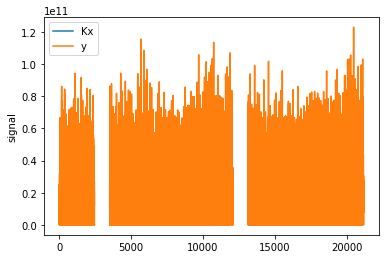

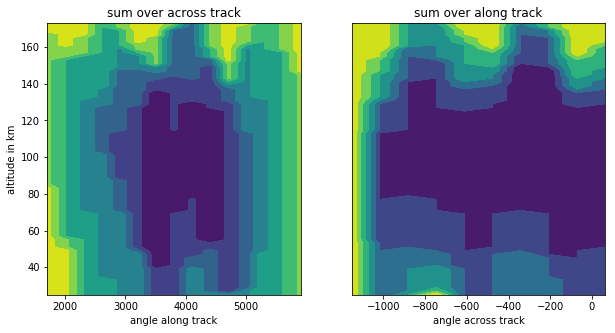

<Figure size 720x360 with 0 Axes>

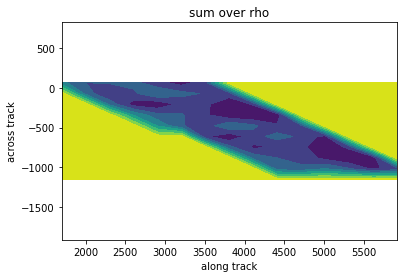

In [81]:
%matplotlib inline
#====check residual
plt.figure()
plt.plot(K_coo.dot(x_hat), label='Kx')
plt.plot(y, label='y')
plt.ylabel('signal')
plt.legend()
plt.show()

#====contour plot 
plt.figure(figsize=(10,5))

plt.subplot(121)
plt.contourf(edges_beta*6371, edges_rho*1e-3, result.sum(axis=0).T)
plt.xlabel('angle along track')
plt.ylabel('altitude in km')
plt.title('sum over across track')

plt.subplot(122)
plt.contourf(edges_alpha*6371, edges_rho*1e-3, result.sum(axis=1).T)
plt.xlabel('angle across track')
#plt.ylabel('altitude')
plt.title('sum over along track')
plt.yticks([])
plt.show()

plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.contourf(edges_beta*6371, edges_alpha*6371, result.sum(axis=2))
ax.axis('equal')
plt.ylabel('across track')
plt.xlabel('along track')
plt.title('sum over rho')
plt.show()

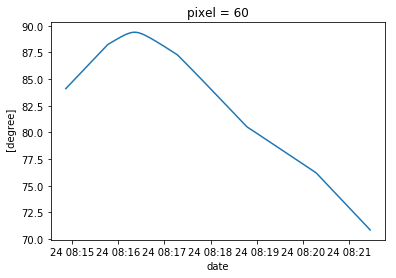

In [83]:
tan_lat.isel(date=im_lst,pixel=60).plot()

<Figure size 432x288 with 0 Axes>

/home/anqil/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1012: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


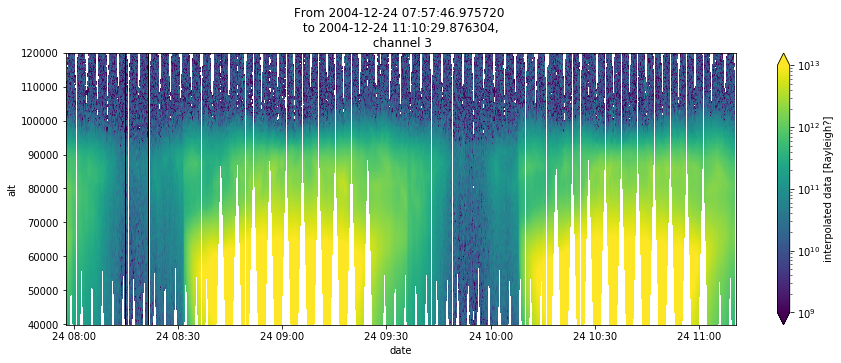

<Figure size 432x288 with 0 Axes>

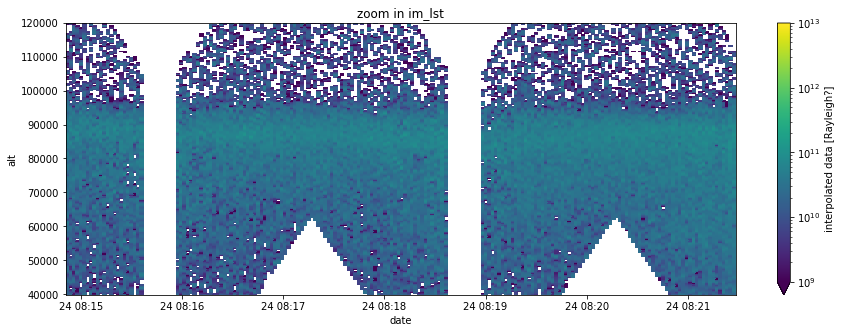

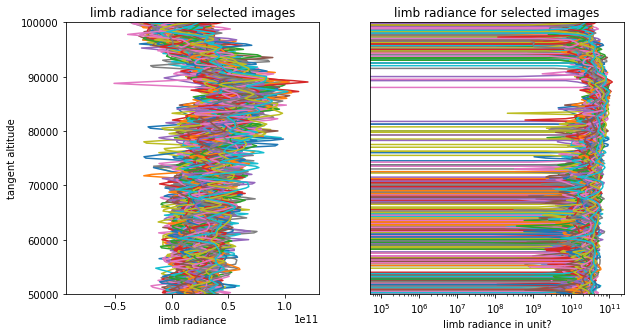

In [84]:
# choose some images to focus
#im_lst = np.arange(1200, 1300)

alts_interp = np.arange(40e3, 120e3, .25e3)
data_interp = []

for (data, alt) in zip(l1, tan_alt):
    f = interp1d(alt, data, bounds_error=False)
    data_interp.append(f(alts_interp))
data_interp = xr.DataArray(data_interp, coords=(date, alts_interp), 
                           dims=('date', 'alt'))
data_interp.attrs['units'] = 'Rayleigh?'
data_interp.attrs['long_name'] = 'interpolated data'

#FIG_SIZE = (15,6)
plt.figure()
data_interp.plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='From {} \n to {}, \n channel {}'.format(num2date(mjd[0],units),
       num2date(mjd[-1], units), ch))
plt.axvline(x=date[im_lst[0]], color='k', linewidth=1)
plt.axvline(x=date[im_lst[-1]], color='k', linewidth=1)
plt.show()

plt.figure()
data_interp.isel(date=im_lst).plot(x='date', y='alt', 
                 norm=LogNorm(), 
                 vmin=1e9, vmax=1e13, 
                 size=5, aspect=3)
ax = plt.gca()
ax.set(title='zoom in im_lst')
plt.show()

plt.figure(figsize=(10,5))
plt.subplot(121)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(ylabel='tangent altitude', 
       xlabel='limb radiance',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])

plt.subplot(122)
plt.plot(data_interp.isel(date=im_lst).T, alts_interp)
ax = plt.gca()
ax.set(xlabel='limb radiance in unit?',
       title='limb radiance for selected images',
       ylim=[50e3,100e3])
ax.set_xscale('log')
plt.yticks([])
plt.show()